In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

%cd -q ../scripts/
from default_param import *

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


#  FLE_limit_cycles




In [2]:
%run experiment_fle.py

Sequence results/FLE-dot-anim.mp4 already exists (remove to recompute)
Studying CONDENSATION by changing image along variable(s) : {'latency': [0, 10]}
Studying CONDENSATION by changing image along variable(s) : {'latency': [0, 10]}
Sequence results/FLE-flash-anim.mp4 already exists (remove to recompute)
Studying CONDENSATION by changing image along variable(s) : {'latency': [0, 10]}
Studying CONDENSATION by changing image along variable(s) : {'latency': [0, 10]}


In [3]:
print('Size of the particles population for all frames', image[stimulus_tag]['result']['MBP'][10].shape)

Size of the particles population for all frames (5, 81920, 100)


['dot', 'flash']
Flash occurs at frame  60 at position 0.00182019748546


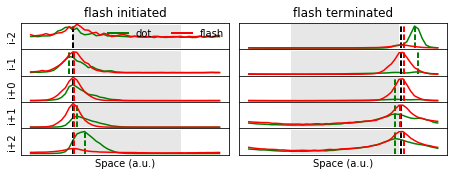

In [4]:
fig, axs = plt.subplots(2*N_frame_av+1, 2, figsize=(fig_width, fig_width/2.618))
for ax in axs.ravel(): 
    ax.axis(c='b', lw=2, axisbg='w')
    ax.set_facecolor('w')
print (stim_labels)
from scipy import special

# detecting time of the max of the flash:
particles = image['flash']['result']['MBP'][10]
v_hist_, x_edges, y_edges = mp.spatial_readout(particles, N_quant_X=N_quant_Y, N_quant_Y=1, display=False)
v_hist_ /= np.sum(v_hist_, axis=0)
x_middle = .5*(x_edges[1:] + x_edges[:-1])
average_pos = np.sum(v_hist_*x_middle[:, np.newaxis], axis=0)
average_std = np.sum(v_hist_*(x_middle[:, np.newaxis]-average_pos[np.newaxis, :])**2, axis=0)
time_ind_max_flash = np.argmin(average_std) 
time_ind_max_flashs = [59, 60] # HACK
#print(x_middle)
t_lags = [-27., 30.] 
#start, end = (50 + t_lags[0])*N_quant_X/N_frame, (50 + t_lags[1])*N_quant_X/N_frame
#print(start, end)
start, end = 11, 40

pos_mean_flash = average_pos[time_ind_max_flash]
print('Flash occurs at frame ', time_ind_max_flash, 'at position', pos_mean_flash)

v_hist = {}
for j, (time_ind_max_flash, t_lag, label_FLE) in enumerate(zip(time_ind_max_flashs, t_lags, ['flash initiated', 'flash terminated'])):
    # getting the max 
    v_hist_max = np.zeros(2*N_frame_av+1)
    for i, i_frame in  enumerate(range(time_ind_max_flash-N_frame_av, time_ind_max_flash+N_frame_av+1)):
        for stimulus_tag in stim_labels:
            particles = image[stimulus_tag]['result']['MBP'][10][:, :, int(i_frame+t_lag*(stimulus_tag=='dot'))]
            v_hist_, x_edges, y_edges = mp.spatial_readout(particles, N_quant_X=N_quant_Y, N_quant_Y=1, display=False)
            v_hist_ /= np.sum(v_hist_, axis=0)
            v_hist_max[i] = np.max((v_hist_max[i], v_hist_.max()))
        
    for k, (stimulus_tag, cmap, color, dashes) in enumerate(zip(stim_labels, [plt.cm.Greens, plt.cm.Reds], ['g', 'r'], [[2, 4], [4, 2]])):
        particles_t = image[stimulus_tag]['result']['MBP'][10].copy()
        for i, i_frame in  enumerate(range(time_ind_max_flash-N_frame_av, time_ind_max_flash+N_frame_av+1)):
            particles = particles_t[:, :, int(i_frame+t_lag*(stimulus_tag=='dot'))]
            if stimulus_tag=='flash':
                particles[0, :] = mp.torus(particles[0, :] + 2.*t_lag/N_frame, w=2.)
                #print (2.*t_lag/N_frame)
                axs[i][j].plot([pos_mean_flash+2.*t_lag/N_frame, pos_mean_flash+2.*t_lag/N_frame], 
                               [0, v_hist_max[i]], ls='--', lw=2, c='k')
                #print(pos_mean_flash+2.*t_lag/N_frame)
                axs[i][j].fill_between(x_middle[start:end], np.zeros_like(x_middle[start:end]), 
                                       v_hist_max[i]* np.ones_like(x_middle[start:end]), #(x_middle>2*dot_start-1) * (x_middle<2*dot_stop-1), 
                                       facecolor=(.1, .1, .1, .1), edgecolor='none', interpolate=False)    
                
            v_hist_, x_edges, y_edges = mp.spatial_readout(particles, N_quant_X=N_quant_Y, N_quant_Y=1, display=False)
            v_hist_ = v_hist_.ravel() / v_hist_.sum()
            #print (v_hist_.shape)

            average_pos_ = np.sum(v_hist_*x_middle)
            average_std = np.sqrt(np.sum(v_hist_*(x_middle-average_pos_)**2))

            axs[i][j].plot(x_middle, v_hist_ * v_hist_.max() / v_hist_max[i]* .92, c=color)
            

            #print (average_pos_, average_std)
            #axs[i][j].plot([average_pos_, average_pos_], [0, v_hist_max], ls='--', lw=2, c=color)
            pos_max = x_middle[np.argmax(v_hist_)] + k/N_frame
            if average_std < 0.56:
                #print (pos_max)
                line, = axs[i][j].plot([pos_max, pos_max], [0, v_hist_max[i]], ls='--', lw=2, c=color)
                #line.set_dashes(dashes)

            #print (stimulus_tag, label_FLE, pos_max)
            if i < time_ind_max_flash+N_frame_av:
                plt.setp(axs[i][j], xticks=[], yticks=[])
            axs[i][0].set_ylabel('i{:+d}'.format(i_frame-time_ind_max_flash))

            
        axs[0][0].plot([0], [0], lw=2, c=color, label=stimulus_tag)
        if j is 0: axs[0][0].legend(bbox_to_anchor=(0., 1.02, 1.02, .102), 
           ncol=2, loc='upper right', frameon=False)
    axs[0][j].set_title(label_FLE)
    axs[i][j].set_xlabel('Space (a.u.)')

plt.tight_layout()
fig.subplots_adjust(hspace = .0, wspace = .05, left=0.04, bottom=0.1, right=.99, top=.87)

for ext in FORMATS: fig.savefig(os.path.join('../figures/', 'FLE_limit_cycles_raw' + ext))

In [5]:
import tikzmagic

In [ ]:
!ls -l ../figures/FLE_limit_cycles*

-rw-r--r--  1 lolo  staff   169184 Jan 23 16:49 ../figures/FLE_limit_cycles.jpg
-rw-r--r--  1 lolo  staff    21877 Jan 23 16:49 ../figures/FLE_limit_cycles.pdf
-rw-r--r--  1 lolo  staff  1230534 Jan 23 16:50 ../figures/FLE_limit_cycles.tiff
-rw-r--r--  1 lolo  staff    21647 Feb 20 15:06 ../figures/FLE_limit_cycles_raw.pdf
-rw-r--r--  1 lolo  staff    26927 Feb 20 15:06 ../figures/FLE_limit_cycles_raw.png


In [ ]:
%%tikz -e ../figures/FLE_limit_cycles.pdf

\newcommand{\tstar}[5]{% inner radius, outer radius, tips, rot angle, options
	\pgfmathsetmacro{\starangle}{360/#3}
	\draw[#5] (#4:#1)
	\foreach \x in {1,...,#3}
		{ -- (#4+\x*\starangle-\starangle/2:#2) -- (#4+\x*\starangle:#1)
		}
		-- cycle;
	}

%\draw[white, fill=white] (-.02\linewidth, 0) rectangle (1.01\linewidth, .41\linewidth) ;

\node [anchor=south west] (label) at (0, 0) {\includegraphics[width=\linewidth]{../figures/FLE_limit_cycles_raw.pdf}};
\begin{scope}[fill=white, scale=.9, xshift=2.8cm, yshift=-.5\textwidth]
 \draw[black, fill=white] (2., 7.) rectangle (4, 8.5) ;
 \draw[black,very thick] (2.4, 8.1) rectangle (2.6, 8.3) ;
 \draw[red, ->, very thick] (2.7, 8.2) -- (3.7, 8.2) ;
 \tstar{0.066}{0.3}{5}{21}{orange,thick,fill=orange, xshift=2.5cm, yshift=7.6cm}
 \draw[black,very thick] (2.4, 7.5) rectangle (2.6, 7.7) ;
\end{scope}
\begin{scope}[fill=white, scale=.9, xshift=5.25cm, yshift=-.5\textwidth]
 \draw[black, fill=white] (2.1, 7.) rectangle (4.1, 8.5) ;
 \draw[black,very thick] (3.6, 8.1) rectangle (3.8, 8.3) ;
 \draw[red, ->, very thick] (2.5, 8.2) -- (3.5, 8.2) ;
 \tstar{0.066}{0.3}{5}{21}{orange,thick,fill=orange, xshift=3.7cm, yshift=7.6cm}
 \draw[black,very thick] (3.6, 7.5) rectangle (3.8, 7.7) ;
\end{scope}
\begin{scope}[font=\bf\sffamily]
    \draw (.02\textwidth, .37\textwidth) node {A};
    \draw (.5375\textwidth, .37\textwidth) node[fill=white] {B};
\end{scope}
            
            

In [ ]:
!convert -density 300 ../figures/FLE_limit_cycles.pdf ../figures/FLE_limit_cycles.jpg
!convert  -density 600  -resize 5400 -units pixelsperinch -flatten  -compress lzw  -depth 8 ../figures/FLE_limit_cycles.pdf ../figures/FLE_limit_cycles.tiff
from IPython.display import SVG, Image
Image('../figures/FLE_limit_cycles.jpg')

## version control

In [ ]:
!git pull

In [ ]:
!git add ../figures/FLE_limit_cycles*
#!git add ../figures/*tiff
#!git rm ../figures/FLE_limit_cycles_raw*
!git status

In [ ]:
!git commit -m' figure FLE_limit_cycles ' ../notebooks/figure_4_FLE_limit_cycles.ipynb ../figures/FLE_limit_cycles* ../khoei17fle.tex 
!#git push